<a href="https://colab.research.google.com/github/fmejias/CienciasDeLosDatosTEC/blob/master/MatematicasCienciasDeLosDatos/TP3/TP3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Matemáticas para Ciencias de los Datos
## Ejemplo mínimos cuadrados

Documento base: María Auxiliadora Mora, Felipe Mejias

In [1]:
# Libraries required 
import torch as torch
import numpy as np
import random
import math

from torch.distributions import constraints
from torch.distributions.distribution import Distribution
from torch.distributions.utils import _standard_normal, lazy_property
from torch.distributions import normal
from torch.distributions import multivariate_normal

import torch.distributions as distrib
import matplotlib.pyplot as plt


## Objetivo
El objetivo del ejemplo es repasar aspectos básicos del algoritmo de mínimos cuadrados aplicado a un ejemplo de clasificación de muestras.

## Actividad
1. Se generarán dos conjuntos de datos ejemplo.  Cada conjunto tendrá dos cúmulos de datos aleatorios que luego serán separados en dos clases. En el primer elemplo los datos serán linealmente separables y en el segundo no. 

2. Se estimará el vector de pesos óptimo utilizando mínimos cuadrados para separar las datos en dos clases.

3. Se estimarán las salidas implementando la función forward que permita clasificar cada uno de los ejemplos.

4. Se evalúa el error, es decir la distancia euclidiana entre la estimación y sus etiquetas.


# 1) Generar conjuntos de datos aleatorios

Se va a utilizar una función para generar un conjunto de datos  $X_{i}\in\mathbb{R}^{m\times 2}$, correspondiente a dos cúmulos de datos con distribución Gaussiana y matrices de covarianza $Σ_{1} y Σ_{2}$.

  ## 1.a) Conjunto de datos A, linealmente separable.
Se definen las matrices de covarianza en función de qué tan dispersos están los datos con respecto a la media.
Un opción para que los datos sean linealmente separables es defirlos:  
   - Para el conjunto de muestras A, la media como [2, 2] y la desviación estándar como [3, 3]
   - Para el conjunto de datos B, la media  como [8, 8] y la desviación  [2, 1]
 
## 1.b) conjunto de datos B, no linealmente separable. Los datos se mezclan moderadamente.
Como se desea que los datos sean no linealmente separables, se pueden definir de la siguiente forma:  
   - Para el conjunto de muestras A, la media como [2, 2] y la desviación estándar como [3, 3]
   - Para el conjunto de datos B, la media como [4, 4] y la desviación  [2, 1]


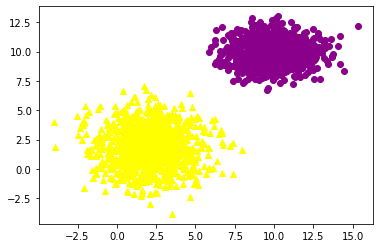

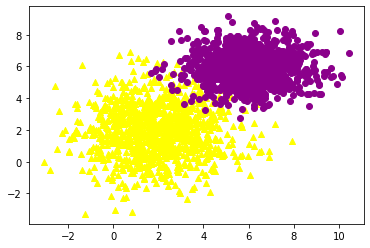

torch.Size([2000, 3])
torch.Size([2000, 1])


In [17]:
"""
Creates the data (2 classes) to be used for training, using a 
Gaussian Mixture Modelling (GMM) distribution
@param numberSamplesPerClass, the number of samples per class
@param mean1, means for samples from the class 1
@param mean2, means for samples from the class 2
@param stds1, standard deviation for samples, class 1
@param stds2, standard deviation for samples, class 2
"""
def createData(numberSamplesPerClass = 2, mean1 = [2, 2], mean2 = [6, 6], stds1 = [3, 3], stds2 = [2, 1]):
    '''
    Creates data with gaussian distribution using the 
    library torch.distributions (multivariate_normal)
    '''
    def createDataOneClass(means, covarianceMatrix, numberSamples):
        # Inits the bi gaussian data generator
        multiGaussGenerator = multivariate_normal.MultivariateNormal(means, covarianceMatrix)
        # Takes the samples
        samples = multiGaussGenerator.sample(torch.Size([numberSamples]))
        return samples
   
    means = torch.zeros(2)

    # Ones to concatenate for bias
    ones = torch.ones(numberSamplesPerClass, 1)
    means[0] = mean1[0]
    means[1] = mean1[1]
    # Covariance matrix creation with identity
    covarianceMatrix = torch.eye(2)
    covarianceMatrix[0, 0] = stds1[0]
    covarianceMatrix[1, 1] = stds1[1]
    samplesClass1 = createDataOneClass(means, covarianceMatrix, numberSamplesPerClass)
    means[0] = mean2[0]
    means[1] = mean2[1]
    covarianceMatrix[0, 0] = stds2[0]
    covarianceMatrix[1, 1] = stds2[1]
    samplesClass2 = createDataOneClass(means, covarianceMatrix, numberSamplesPerClass)
    # Concatenates the ones for the bias
    samplesClass1Bias = torch.cat((ones, samplesClass1), 1)
    samplesClass2Bias = torch.cat((ones, samplesClass2), 1)
    samplesAll = torch.cat((samplesClass1, samplesClass2), 0)
    
    #Plot clases
    plt.scatter(samplesClass1[:, 0], samplesClass1[:, 1], marker='^', c='yellow')
    plt.scatter(samplesClass2[:, 0], samplesClass2[:, 1], marker='o', c='darkmagenta')
    plt.show()
  
    #Create samples with bias
    samplesAllBias = torch.cat((samplesClass1Bias, samplesClass2Bias), 0)
    
    #Create targets
    targetsClass1 = torch.ones(numberSamplesPerClass, 1)
    targetsClass2 = -1 * torch.ones(numberSamplesPerClass, 1)
    targetsAll = torch.cat((targetsClass1, targetsClass2), 0)
    
    return (targetsAll, samplesAllBias)
  

  
# Sample data A
(TargetsAll, SamplesAll) = createData(numberSamplesPerClass = 1000, mean2 = [10, 10])


# Sample data B
(TargetsAllB, SamplesAllB) = createData(numberSamplesPerClass = 1000, mean2 = [6, 6])
  
  
print(SamplesAll.shape) 
print(TargetsAll.shape)

# 2) Se estima el vector de pesos óptimo utilizando mínimos cuadrados

In [18]:
def estimateOptimumW(TargetsAll, SamplesAll):
    """ Estimate the optimum W with NO FORS
    param TargetsAll, NumSamples x 1 matrix with target values (1 or -1)
    param SamplesAll, NumSamples x NumDimensions 
    return wOpt, array with optimum weights
    """
    # Calculate w = *Apinverse*Targets
    samplesAllPinv = torch.tensor(np.linalg.pinv(SamplesAll))
    wOpt = samplesAllPinv.mm(TargetsAll)
    
    return wOpt
  
# Optimun w for sample data A  
wOpt = estimateOptimumW(TargetsAll, SamplesAll)

# Optimun w for sample data B  
wOptB = estimateOptimumW(TargetsAllB, SamplesAllB)

print(wOpt.shape)

torch.Size([3, 1])


# 3) Se estiman las salidas implementando la función forward 
La función forward estima las salidas, del modelo al hacer  $T =f(X\,\vec{w}_{opt})$

donde la función f(x) se refiere a la función de activación, la cuál decide a cuál clase pertenece cada muestra, según el resultado del producto punto de las muestra y los pesos óptimos, en este caso simplemente usando la función signo o escalón, es decir:

\begin{equation}
f(X\,\vec{w}_{opt}) = 1, si  (x>0),
\\
      = -1, si (x<=0)
\end{equation}

In [4]:
def forward(SamplesAll, wOpt):
    """
    Get model output
    param SamplesAll, a matrix with dimensions NumSamples x NumDimensions 
    return: Estimates the model outputs using the step activation function 
            with values of -1 and 1.   
    """
    EstimatedTargets = SamplesAll.mm(wOpt)
    
    EstimatedTargets[EstimatedTargets > 0] = 1
    EstimatedTargets[EstimatedTargets <= 0] = -1
     
    return EstimatedTargets

# Estimated target for sample data A    
EstimatedTargetsAll = forward(SamplesAll, wOpt)

# Estimated target for sample data B    
EstimatedTargetsAllB = forward(SamplesAllB, wOptB)



# 4) Se evalúa la distancia euclidiana entre la estimación y sus etiquetas para calcular el error.

In [11]:
def evaluateError(TargetsAll, EstimatedTargetsAll):
    """
    Evaluate model error using the euclidian distance.
    param TargetsAll, real targets
    param EstimatedTargets
    """
    error = torch.norm(TargetsAll - EstimatedTargetsAll, 2)
    return error
  
  
# Error for sample data A    
error = evaluateError(TargetsAll, EstimatedTargetsAll)

# Error for sample data B    
errorB = evaluateError(TargetsAllB, EstimatedTargetsAllB)


# 5) Se reporta el error al usar los dos conjuntos de datos generados anteriormente 

tensor([[ 1.4204],
        [-0.1076],
        [-0.1280]])


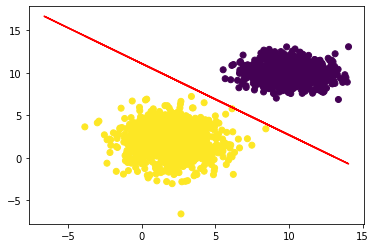

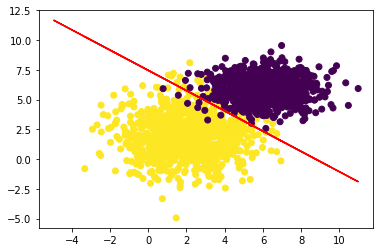

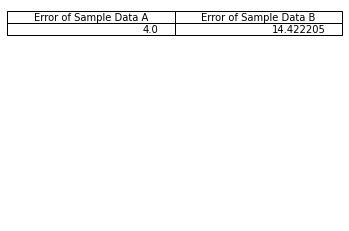

In [12]:
def plotBestFitLine(SamplesAll, wOpt, targets):
    #Plot the best fit line using wOpt, the samples and targets.
    
    # Solve Y using the optimal weights for the linear separator. 
    # Where wOpt[0] + wOpt[2]Y + (wOpt[1] * SamplesAll) = 0
    
    Y = (-wOpt[0] - (wOpt[1] * SamplesAll)) / wOpt[2]
    
    # plot the original data along with the line of best fit
    plt.figure()
    plt.scatter(SamplesAll[:, 1].numpy(), SamplesAll[:, 2].numpy(), marker="o", 
                  c=targets.transpose(0, 1)[0])
    plt.plot(SamplesAll.numpy(), Y.numpy(), "r-")
    
    
# Plot best line fit for sample data A
plotBestFitLine(SamplesAll, wOpt, TargetsAll)


# Plot best line fit for sample data B
plotBestFitLine(SamplesAllB, wOptB, TargetsAllB)

#Print errors
fig, ax = plt.subplots()

# Hide axes
ax.xaxis.set_visible(False) 
ax.yaxis.set_visible(False)
ax.axis("off")

collabel=("Error of Sample Data A", "Error of Sample Data B")
ax.table(cellText=[[error.numpy(),errorB.numpy()]],colLabels=collabel,loc='upper center')

print(wOpt)